# Goalball LSTM – Data Preparation Pipeline
This notebook loads the three *_Throws_lstm_training.csv* files, normalises
coordinates by the matching video width × height, engineers features, and
outputs NaN-free tensors ready for the LSTM model.


## Import data


In [1]:
import pandas as pd, numpy as np, cv2, subprocess, json
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import glob
from datetime import timedelta
from pathlib import Path
import json

USE_LSTM_PREDICTIONS_IF_AVAILABLE = False
DATA_ROOT = Path(r"C:\Users\USER\Desktop\Thesis\Paralkympics2024")   


# games = ["ISR_-_CAN_5-1", "TUR_-_BRA_3-1", "ISR_-_BRA_8-4"]
games = ["ISR_-_CAN_5-1", "TUR_-_BRA_3-1", "TUR_-_ISR_5-4", "ISR_-_BRA_8-4","CHI_-_TUR_7-5", "BRA_-_TUR_3-3"]

train_csvs = [
    DATA_ROOT / games[3] / "outputs" / f"{games[3]}_Throws_lstm_training.csv",
    DATA_ROOT / games[2] / "outputs" / f"{games[2]}_Throws_lstm_training.csv",
    DATA_ROOT / games[5] / "outputs" / f"{games[5]}_Throws_lstm_training.csv",
    DATA_ROOT / games[0] / "outputs" / f"{games[0]}_Throws_lstm_training.csv",
    DATA_ROOT / games[4] / "outputs" / f"{games[4]}_Throws_lstm_training.csv",
]
test_csv   = DATA_ROOT / games[1] / "outputs" / f"{games[1]}_Throws_lstm_training.csv"
game = (Path(test_csv).stem).replace("_Throws_lstm_training", "")

#goal prediction csv path
goal_pred_csv = Path(f"Thesis/Paralkympics2024/{game}/outputs/{game}_goal_preds.csv")

# Load extra goal files and append to train_csvs
extra_goal_files = glob.glob(r"C:\Users\USER\Desktop\Thesis\Goals_Paralympics\outputs\*.csv")


extra_goal_paths = [Path(f) for f in extra_goal_files]
print(f"Found {len(extra_goal_paths)} extra goal files.")
train_csvs.extend(extra_goal_paths)


print(f"Train set: {train_csvs}")
print(f"Test set: {test_csv}")




Found 17 extra goal files.
Train set: [WindowsPath('C:/Users/USER/Desktop/Thesis/Paralkympics2024/ISR_-_BRA_8-4/outputs/ISR_-_BRA_8-4_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/Paralkympics2024/TUR_-_ISR_5-4/outputs/TUR_-_ISR_5-4_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/Paralkympics2024/BRA_-_TUR_3-3/outputs/BRA_-_TUR_3-3_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/Paralkympics2024/ISR_-_CAN_5-1/outputs/ISR_-_CAN_5-1_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/Paralkympics2024/CHI_-_TUR_7-5/outputs/CHI_-_TUR_7-5_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/Goals_Paralympics/outputs/GOALS_Berlin25_ISR5_ENG1_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/Goals_Paralympics/outputs/GOALS_F_Tokyo2024_ISR3_JAP1_Throws_lstm_training.csv'), WindowsPath('C:/Users/USER/Desktop/Thesis/Goals_Paralympics/outputs/GOALS_Paralympics24_Canada1_Japan

## Data Pre-proccessing

 Helper ① · Find matching video (.mp4 / .mov)

In [2]:
def find_video_for_csv(csv_path: Path) -> Path | None:
    """Return the first .mp4 or .mov file in the game folder (one level above outputs)."""
    game_dir = csv_path.parent.parent
    vids = list(game_dir.glob("*.mp4")) + list(game_dir.glob("*.mov"))
    return vids[0] if vids else None


 Helper ② · Get video resolution

In [3]:
def get_video_dims(video_path: Path, fallback=(1920, 1080)):
    """Return (W,H). 1) try OpenCV; 2) try ffprobe; 3) fallback."""
    cap = cv2.VideoCapture(str(video_path))
    w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    if w and h:
        return w, h
    # ffprobe—catches ProRes .mov etc.
    try:
        out = subprocess.check_output(
            ["ffprobe", "-v", "error", "-select_streams", "v:0",
             "-show_entries", "stream=width,height", "-of", "json", str(video_path)],
            stderr=subprocess.STDOUT
        )
        meta = json.loads(out)
        return meta["streams"][0]["width"], meta["streams"][0]["height"]
    except Exception:
        return fallback


 Helper 3 · frame format


In [4]:
def frame_to_timestamp(frame_idx, fps):
    """
    Convert 1-based frame index to a human-readable video timestamp.
    Returns 'HH:MM:SS.mmm' (zero-padded).
    """
    if frame_idx is None:
        return None
    # In OpenCV we were iterating 1-based frames; convert to seconds
    seconds = float(frame_idx) / float(max(fps, 1e-6))
    whole = int(seconds)
    ms = int(round((seconds - whole) * 1000))
    h = whole // 3600
    m = (whole % 3600) // 60
    s = (whole % 60)
    return f"{h:02d}:{m:02d}:{s:02d}.{ms:03d}"


Build (csv ➜ (W,H)) mapping

In [5]:
dims = {}    # csv Path  ->  (W, H)

for csv in train_csvs + [test_csv]:
    vid = find_video_for_csv(csv)
    dims[csv] = get_video_dims(vid) if vid else (1920, 1080)
    print(csv.name, "↔", vid.name if vid else "<no video>", ":", dims[csv])


ISR_-_BRA_8-4_Throws_lstm_training.csv ↔ ISR_-_BRA_8-4.mov : (1920, 1080)
TUR_-_ISR_5-4_Throws_lstm_training.csv ↔ <no video> : (1920, 1080)
BRA_-_TUR_3-3_Throws_lstm_training.csv ↔ <no video> : (1920, 1080)
ISR_-_CAN_5-1_Throws_lstm_training.csv ↔ <no video> : (1920, 1080)
CHI_-_TUR_7-5_Throws_lstm_training.csv ↔ CHI_-_TUR_7-5.mov : (1920, 1080)
GOALS_Berlin25_ISR5_ENG1_Throws_lstm_training.csv ↔ GOALS_Berlin25_ISR5_ENG1.mp4 : (1774, 1504)
GOALS_F_Tokyo2024_ISR3_JAP1_Throws_lstm_training.csv ↔ GOALS_Berlin25_ISR5_ENG1.mp4 : (1774, 1504)
GOALS_Paralympics24_Canada1_Japan2_Throws_lstm_training.csv ↔ GOALS_Berlin25_ISR5_ENG1.mp4 : (1774, 1504)
GOALS_Paralympics24_China3_Brazil1_Throws_lstm_training.csv ↔ GOALS_Berlin25_ISR5_ENG1.mp4 : (1774, 1504)
GOALS_Paralympics24_Final_Israel3_Turkey8_Throws_lstm_training.csv ↔ GOALS_Berlin25_ISR5_ENG1.mp4 : (1774, 1504)
GOALS_Paralympics24_Israel1_China6_Throws_lstm_training.csv ↔ GOALS_Berlin25_ISR5_ENG1.mp4 : (1774, 1504)
GOALS_Paralympics24_Israe

Helper ③ · clean_throw() (one segment)

After these operations the DataFrame g contains only dense numeric features (plus the new mask), perfectly ordered for sequence packing, and ready to be merged back into the full game table.

In [6]:
BALL_COLS = ["ball_x","ball_y","ball_w","ball_h","ball_conf"]
THROWER_COLS  = ["thrower_x","thrower_y","thrower_w","thrower_h","thrower_conf"]
DEFENDER_COLS = ["defender_x","defender_y","defender_w","defender_h","defender_conf"]

def clean_throw(g: pd.DataFrame, W: float, H: float) -> pd.DataFrame:
    # 1 ─ guarantee outcome token. 
    # Guarantees every throw has a legal (outcome, label) pair → later mapping to the six-class target never fails.
    g.loc[g["label"] == 0, "outcome"] = g.loc[g["label"] == 0, "outcome"].fillna("o")
    
    # 2 ─ chronological order
    # Orders the frames chronologically and then re-indexes them from 0…n-1. 
    # The LSTM’s sense of time comes only from row order; sorting eliminates annotation out-of-order glitches
    g = g.sort_values("frame").reset_index(drop=True)

    # 3 ─ detection mask + NaN fill
    # Adds a mask: 1 if the ball was actually detected this frame, 0 otherwise. 
    # Lets the model learn when coordinates are trustworthy vs. forward-filled guesses.
    g["ball_seen"] = (~g["ball_conf"].isna()).astype(int) 
    g["thrower_seen"]  = (~g["thrower_conf"].isna()).astype(int)
    g["defender_seen"] = (~g["defender_conf"].isna()).astype(int)

    # Forward-fill, then back-fill every NaN in the five ball geometry columns within the throw.
    # Creates a continuous trajectory even if a detector missed a few frames.
    for cols in (BALL_COLS, THROWER_COLS, DEFENDER_COLS):
        g[cols] = g[cols].ffill().bfill()

    # 4 ─ coordinate normalisation\
    # Converts absolute pixels to unit-square [0,1] values.
    # Makes the model resolution-agnostic (works on 1080 p and 720 p).
    for actor in ("ball", "thrower", "defender"):
        g[f"{actor}_x"] /= W
        g[f"{actor}_w"] /= W
        g[f"{actor}_y"] /= H
        g[f"{actor}_h"] /= H
    
    # 5 ─ time cues & velocity
    # Adds a relative-time feature: 0 at first frame, 1 at last.
    # Gives the LSTM an explicit notion of “early vs. late” in the throw.
    g["rel_t"] = g.index / (len(g) - 1) if len(g) > 1 else 0.0

    #Stores the difference in original frame numbers (can be >1 if frames were skipped).
    #Signals irregular sampling / detector dropouts. e.g: Frames 901, 902, 907 → gaps 0, 1, 5.
    g["gap"]   = g["frame"].diff().fillna(0)

    # First-order difference of normalised ball_x, ball_y → velocity per frame.
    # Motion often distinguishes outs (fast, wide) vs. blocks/goals (slows near defenders).
    # If ball_x goes 0.70 → 0.75 → 0.81 the ball_dx are 0, 0.05, 0.06.
    g[["ball_dx","ball_dy"]] = g[["ball_x","ball_y"]].diff().fillna(0)
    
    # 6 ─ binary encode segment_type
    # Encodes the string from/to as 0/1.
    # Cheap categorical info: “wind-up” vs. “release” phase of the throw.
    # 'from' → 0 ; 'to' → 1.
    g["segment_type"] = (g["segment_type"] == "to").astype(int)
    return g


Helper ④ · preprocess_full() (whole game)

In [7]:
CLS = {('o',1):0, ('o',0):1, ('g',1):2, ('g',0):3, ('b',1):4, ('b',0):5}

def preprocess_full(df_raw: pd.DataFrame, W: float, H: float,  uid_col: str = "throw_uid") -> pd.DataFrame:
    # A. apply clean_throw per segment
    df = (df_raw
          .groupby(uid_col, group_keys=False)
          .apply(clean_throw, W=W, H=H)
          .reset_index(drop=True))
    # B. add six-class target
    def add_class(g):
        # ── find the first non-null outcome inside the group ──
        non_null = g["outcome"].dropna()
        outcome  = non_null.iloc[0] if len(non_null) else "o"   # fallback
        
        label    = int(g["label"].iloc[0])   # 0 = false, 1 = real/valid
        g["class_id"] = CLS[(outcome, label)]
        return g

    df = df.groupby("throw_uid", group_keys=False).apply(add_class)
    # C. drop leaks / sparse cols
    drop_cols = ["frame","label","outcome"] 
    return df.drop(columns=drop_cols)


In [8]:
# === Binary goal-vs-rest mapping ===
GOAL_CLASS_IDS = {CLS[('g',1)], CLS[('g',0)]}   # {2,3} in your current map


Run pre-processing on all CSV files

In [9]:
# helper to load → clean one csv

def load_and_clean(csv_path: Path):
    raw       = pd.read_csv(csv_path)

    # ── use the file’s own tag so every game has a private namespace ──
    game_tag  = csv_path.stem.split("_Throws")[0]        # e.g. GOALS_Paralympics24_Turkey5_Israel4
    raw["segment_uid"] = raw["segment_id"].astype(str).radd(f"{game_tag}_")

    raw["throw_uid"]   = (raw["segment_id"] + 1)//2
    raw["throw_uid"]   = raw["throw_uid"].astype(str).radd(f"{game_tag}_")

    W, H = dims[csv_path]          # keeps working as before
    return preprocess_full(raw, W, H, uid_col="throw_uid")

df_train_clean = pd.concat([load_and_clean(p) for p in train_csvs],
                           ignore_index=True)
df_test_clean  = load_and_clean(test_csv)

print("train clean:", df_train_clean.shape, " test clean:", df_test_clean.shape)
print(f"-----------distinct throw_uids in train: {df_train_clean['throw_uid'].nunique()}----------------")
print(df_train_clean.head(3))

C:\Users\USER\AppData\Local\Temp\ipykernel_21020\2054764792.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df_raw
C:\Users\USER\AppData\Local\Temp\ipykernel_21020\2054764792.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("throw_uid", group_keys=False).apply(add_class)
C:\Users\USER\AppData\Local\Temp\ipykernel_21020\2054764792.py:5: DeprecationWarning: DataFrameGroupBy.apply

train clean: (137673, 27)  test clean: (23613, 27)
-----------distinct throw_uids in train: 1229----------------
   segment_id  segment_type    ball_x    ball_y    ball_w    ball_h  \
0           1             0  0.309021  0.436945  0.019773  0.033826   
1           1             0  0.305917  0.435325  0.019106  0.033519   
2           1             0  0.304375  0.423746  0.016054  0.030574   

   ball_conf  thrower_x  thrower_y  thrower_w  ...      segment_uid  \
0   0.869101   0.318821   0.448167   0.046224  ...  ISR_-_BRA_8-4_1   
1   0.843102   0.315926   0.448966   0.046655  ...  ISR_-_BRA_8-4_1   
2   0.859787   0.315074   0.448416   0.042821  ...  ISR_-_BRA_8-4_1   

         throw_uid  ball_seen  thrower_seen  defender_seen     rel_t  gap  \
0  ISR_-_BRA_8-4_1          1             1              0  0.000000  0.0   
1  ISR_-_BRA_8-4_1          1             1              0  0.010526  1.0   
2  ISR_-_BRA_8-4_1          1             1              0  0.021053  1.0   

    ball

C:\Users\USER\AppData\Local\Temp\ipykernel_21020\2054764792.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = (df_raw
C:\Users\USER\AppData\Local\Temp\ipykernel_21020\2054764792.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("throw_uid", group_keys=False).apply(add_class)


In [10]:
df_train_clean.head(3)


,segment_id,segment_type,ball_x,ball_y,ball_w,ball_h,ball_conf,thrower_x,thrower_y,thrower_w,...,segment_uid,throw_uid,ball_seen,thrower_seen,defender_seen,rel_t,gap,ball_dx,ball_dy,class_id
0,1,0,0.309021,0.436945,0.019773,0.033826,0.869101,0.318821,0.448167,0.046224,...,ISR_-_BRA_8-4_1,ISR_-_BRA_8-4_1,1,1,0,0.000000,0.0,0.000000,0.000000,4
1,1,0,0.305917,0.435325,0.019106,0.033519,0.843102,0.315926,0.448966,0.046655,...,ISR_-_BRA_8-4_1,ISR_-_BRA_8-4_1,1,1,0,0.010526,1.0,-0.003104,-0.001620,4
2,1,0,0.304375,0.423746,0.016054,0.030574,0.859787,0.315074,0.448416,0.042821,...,ISR_-_BRA_8-4_1,ISR_-_BRA_8-4_1,1,1,0,0.021053,1.0,-0.001543,-0.011579,4


Lightly reduce the majority-class (b1 = class_id 4) to 50 %

In [11]:
# import numpy as np
# import pandas as pd
# print("Rows  before down-sample :", len(df_train_clean))

# b1_mask  = df_train_clean["class_id"] == 4          # 4  = ('b',1)
# keep_b1  = df_train_clean[b1_mask].sample(frac=0.50, random_state=0)
# df_train_clean = pd.concat([df_train_clean[~b1_mask], keep_b1])

# print("Rows  after down-sample :", len(df_train_clean))
# print(df_train_clean["class_id"].value_counts().sort_index())

 Horizontal-flip data-augmentation 

 horizontal-mirror data-augmentation for class g1 (mirror flipping)


In [12]:
# –––  Data-augmentation: left↔right mirror for g1 throws –––
def mirror_throw(df_one):
    df_flip = df_one.copy()
    # 1) reflect X coordinates (normalised 0‒1)
    for col in ["ball_x", "thrower_x", "defender_x"]:
        df_flip[col] = 1.0 - df_flip[col]
    # 2) flip X velocities (dx); dy unchanged
    df_flip["ball_dx"] *= -1
    return df_flip

g1_id  = CLS[('g',1)]          # == 2
flip_df = (df_train_clean
           .loc[df_train_clean["class_id"] == g1_id]
           .groupby("throw_uid", group_keys=False)
           .apply(mirror_throw))

# new unique IDs so they don't collide at collate-time
flip_df["throw_uid"] = flip_df["throw_uid"].astype(str) + "_flip"

df_train_clean = pd.concat([df_train_clean, flip_df], ignore_index=True)
print("After mirroring:", df_train_clean['class_id'].value_counts().sort_index())



# multiple targets to flip                                        ---- uses augmentation to out aswell as goals.
# # class IDs you want to mirror
# targets_to_flip = [CLS[('g', 1)],   # g1  == 2
#                    CLS[('o', 1)]]   # o1  == 0

# flip_dfs = []
# for cid in targets_to_flip:
#     flip_part = (df_train_clean
#                  .loc[df_train_clean["class_id"] == cid]
#                  .groupby("throw_uid", group_keys=False)
#                  .apply(mirror_throw))

#     # make new unique IDs so they don’t collide at collate-time
#     flip_part["throw_uid"] = flip_part["throw_uid"].astype(str) + f"_flip{cid}"
#     flip_dfs.append(flip_part)

# # append all mirrored rows to the training frame
# df_train_clean = pd.concat([df_train_clean, *flip_dfs], ignore_index=True)

# print("After mirroring:", df_train_clean['class_id'].value_counts().sort_index())


After mirroring: class_id
0     10101
1      4976
2     37012
4    104090
Name: count, dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_21020\32287703.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(mirror_throw))


Standard-scale every numeric feature

StandardScaler subtracts the training mean and divides by the
training standard deviation for each column, so every feature now
has roughly mean 0 and std 1. This helps the optimizer converge
faster and prevents any single feature (e.g. gap) from dominating
the gradient.

In [13]:
from sklearn.preprocessing import StandardScaler

FEATURE_COLS = [
    # timing & category
    "segment_type", "rel_t", "gap",
    # masks
    "defender_seen", "thrower_seen", "ball_seen",
    # ball    (7)
    "ball_x","ball_y","ball_dx","ball_dy","ball_w","ball_h","ball_conf",
    # thrower (5)
    "thrower_x","thrower_y","thrower_w","thrower_h","thrower_conf",
    # defender (5)
    "defender_x","defender_y","defender_w","defender_h","defender_conf",
]                               # 25 features total

# final safety pass: replace any leftover NaNs with 0
df_train_clean[FEATURE_COLS] = df_train_clean[FEATURE_COLS].fillna(0.0)
df_test_clean [FEATURE_COLS] = df_test_clean [FEATURE_COLS].fillna(0.0)

scaler = StandardScaler()
df_train_clean[FEATURE_COLS] = scaler.fit_transform(df_train_clean[FEATURE_COLS])
df_test_clean [FEATURE_COLS] = scaler.transform   (df_test_clean [FEATURE_COLS])


print("Scaling ✓  |  Train rows:", len(df_train_clean),
      " Test rows:", len(df_test_clean))
print("unique segment IDs train:", df_train_clean["throw_uid"].nunique())
print("unique segment IDs test :", df_test_clean ["throw_uid"].nunique())



Scaling ✓  |  Train rows: 156179  Test rows: 23613
unique segment IDs train: 1369
unique segment IDs test : 212


## Hand it to PyTorch


 Convert each throw to a sequence tensor

In [14]:
# import numpy as np
# import torch
# import torch.nn as nn

# device = "cuda" if torch.cuda.is_available() else "cpu"

# def make_sequences_binary(df):
#     """
#     Groups by throw_uid → returns:
#       seqs: list of float32 arrays [T, F]
#       labels: binary per-throw labels (1 = goal, 0 = rest)
#     """
#     seqs, labels = [], []
#     for _, g in df.groupby("throw_uid"):
#         X = g[FEATURE_COLS].values.astype("float32")
#         cid = int(g["class_id"].iloc[0])
#         y  = 1 if cid in GOAL_CLASS_IDS else 0
#         seqs.append(X)
#         labels.append(y)
#     return seqs, np.array(labels, dtype=np.int64)

# # binary sequences now
# train_seqs, train_labels = make_sequences_binary(df_train_clean)
# test_seqs,  test_labels  = make_sequences_binary(df_test_clean)

# # ── class-frequency weights (rare class ⇒ larger weight) ─────────────────
# freq      = np.bincount(train_labels, minlength=6)
# mask      = freq > 0                    # only classes that exist in training
# class_w    = torch.zeros(6, device=device, dtype=torch.float32)


# class_w[mask] = torch.sqrt(torch.tensor(1.0 / freq[mask],
#                                         dtype=torch.float32,
#                                         device=device))

# # class_w[2] *= 2  # boost the 'g1' class weight
# # class_w[0] *= 0.5  # boost the 'o1' class weight
# # class_w[1] *= 0.5


# print("Per-class weights:", class_w.cpu().numpy())

# # ── focal-loss function (γ = 2) ──────────────────────────────────────
# γ = 2
# def focal_loss(logits, y):
#     ce = nn.functional.cross_entropy(
#             logits, y, reduction='none', weight=class_w)
#     pt = torch.softmax(logits, 1).gather(1, y[:, None]).squeeze()
#     return ((1 - pt) ** γ * ce).mean()


# print("Detects (From&To)  train / test :", len(train_seqs), "/", len(test_seqs))
# print("Example tensor shape :", train_seqs[0].shape)


## LSTM Model Training

In [15]:
import torch, numpy as np
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import collections, torch, numpy as np

Dataset + collate fn

Turn each throw tensor + label into a PyTorch Dataset;
collate pads variable-length sequences so a whole batch fits in one tensor.

In [16]:
class ThrowDataset(torch.utils.data.Dataset):
    def __init__(self, seqs, labels):
        self.seqs   = [torch.tensor(s) for s in seqs]
        self.labels = torch.tensor(labels)
    def __len__(self):  return len(self.seqs)
    def __getitem__(self, idx):  return self.seqs[idx], self.labels[idx]

def collate(batch):
    xs, ys = zip(*batch)
    lengths = torch.tensor([len(x) for x in xs])
    xs_pad  = pad_sequence(xs, batch_first=True)        # → [B, T_max, 23]
    return xs_pad, lengths, torch.tensor(ys)


Sequences → DataLoaders

Groups every throw_uid, builds (T × 23) tensors, then wraps them
in shuffled train-loader and ordered test-loader.

In [17]:
from torch.utils.data import random_split, DataLoader
# 1) Build BINARY sequences (goal vs rest) and return uids in-order
def make_sequences_binary(df, return_uids=False):
    """
    Returns:
      seqs:   list of float32 arrays [T, F]
      labels: np.int64 array {0,1} per throw (1 = goal)
      uids:   list[str] of throw_uid in the SAME order as seqs (if return_uids=True)
    """
    seqs, labels, uids = [], [], []
    # IMPORTANT: keep original order (sort=False)
    for uid, g in df.groupby("throw_uid", sort=False):
        X = g[FEATURE_COLS].values.astype("float32")
        cid = int(g["class_id"].iloc[0])
        y  = 1 if cid in GOAL_CLASS_IDS else 0
        seqs.append(X); labels.append(y); uids.append(uid)
    labels = np.array(labels, dtype=np.int64)
    return (seqs, labels, uids) if return_uids else (seqs, labels)

# Use return_uids=True so we can align predictions later
train_seqs, train_labels, train_throw_uids = make_sequences_binary(df_train_clean, return_uids=True)
test_seqs,  test_labels,  test_throw_uids  = make_sequences_binary(df_test_clean,  return_uids=True)


# 2) Oversample positives with a WeightedRandomSampler (binary, no 'freq' needed)
from torch.utils.data import DataLoader

# inverse-frequency class weights (2 classes: 0,1)
class_counts = np.bincount(train_labels, minlength=2)
w_per_class = np.zeros(2, dtype=np.float32)
mask = class_counts > 0
w_per_class[mask] = class_counts.sum() / (2.0 * class_counts[mask])

# stronger boost to positives if you want (optional):
# w_per_class[1] *= 1.5  # uncomment to push recall even more

sample_w = torch.tensor([w_per_class[l] for l in train_labels], dtype=torch.float32)

sampler = torch.utils.data.WeightedRandomSampler(
    weights     = sample_w,
    num_samples = len(train_labels) * 3,   # ~3 "epochs" worth each pass
    replacement = True
)

# 3) DataLoaders (binary)
BATCH_SIZE = 64

train_loader = DataLoader(
    ThrowDataset(train_seqs, train_labels),
    batch_size = BATCH_SIZE,
    sampler    = sampler,
    collate_fn = collate
)

test_loader  = DataLoader(
    ThrowDataset(test_seqs,  test_labels),
    batch_size = BATCH_SIZE,
    shuffle    = False,
    collate_fn = collate
)

print("Total sequences  train / test :", len(train_seqs), "/", len(test_seqs))
print("Positives (goals) train / test:", int(train_labels.sum()), "/", int(test_labels.sum()))
print("Negatives (rest)  train / test:", int((train_labels==0).sum()), "/", int((test_labels==0).sum()))


Total sequences  train / test : 1369 / 212
Positives (goals) train / test: 280 / 5
Negatives (rest)  train / test: 1089 / 207


Bi-directional LSTM

Two-layer Bi-LSTM reads the padded sequence; the concat of last forward &
backward hidden states feeds a small MLP head that outputs 6 logits.


In [18]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ThrowLSTM(nn.Module):
    """
    BiLSTM + attention → SINGLE logit (goal vs rest)
    """
    def __init__(self, n_features, hidden=128, layers=2, dropout=0.3, bidir=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            bidirectional=bidir,
            dropout=dropout if layers > 1 else 0.0
        )
        out_dim = hidden * (2 if bidir else 1)

        # simple additive attention: w: [D]->[1]
        self.attn = nn.Linear(out_dim, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

        # 1-logit head for BCEWithLogitsLoss
        self.head = nn.Linear(out_dim, 1)

    def forward(self, x, lengths):
        # x: [B, T, F]; lengths: [B]
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        H, _ = pad_packed_sequence(packed_out, batch_first=True)  # [B, T, D]

        B, T, D = H.shape
        idxs = torch.arange(T, device=H.device).unsqueeze(0).expand(B, T)
        mask = idxs >= lengths.unsqueeze(1)   # True at pad positions

        scores = self.attn(H).squeeze(-1)           # [B, T]
        scores = scores.masked_fill(mask, -1e9)
        weights = torch.softmax(scores, dim=1)      # [B, T]
        ctx = (H * weights.unsqueeze(-1)).sum(dim=1)  # [B, D]

        z = self.dropout(ctx)
        logit = self.head(z).squeeze(-1)           # [B]
        return logit, weights


Training loop (20 epochs)

For each epoch we run one pass over train-loader (updates weights) and
one pass over test-loader (no grad).
Print accuracy and cross-entropy loss every epoch.

In [19]:
# model  = ThrowLSTM(n_features=23, hidden=128, layers=2, n_classes=6).to(device)
# print(F"NN {model}")

In [20]:
from datetime import datetime
import math, numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"
model  = ThrowLSTM(n_features=len(FEATURE_COLS), hidden=128, layers=2, dropout=0.3, bidir=True).to(device)

# ← push recall: upweight positives (tune 5–15)
POS_WEIGHT = 3
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([POS_WEIGHT], device=device))

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
MAX_EPOCHS = 40
GRAD_CLIP  = 5.0
MIN_PRECISION = 0.15   # accept low precision to get very high recall

def run_epoch(loader, train=True):
    if train: model.train()
    else:     model.eval()
    losses = []
    with torch.set_grad_enabled(train):
        for X, lengths, y in loader:
            X, lengths, y = X.to(device), lengths.to(device), y.float().to(device)
            if train: opt.zero_grad()
            logits, _ = model(X, lengths)
            loss = loss_fn(logits, y)
            if train:
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                opt.step()
            losses.append(loss.item() * X.size(0))
    return sum(losses) / len(loader.dataset)

@torch.no_grad()
def collect_probs(loader):
    model.eval()
    all_logits, all_y = [], []
    for X, lengths, y in loader:
        X, lengths = X.to(device), lengths.to(device)
        logits, _ = model(X, lengths)
        all_logits.append(logits.cpu())
        all_y.append(y)
    logits = torch.cat(all_logits).numpy()
    y_true = torch.cat(all_y).numpy()
    probs  = 1.0 / (1.0 + np.exp(-logits))
    return probs, y_true

def choose_threshold(probs, y_true, min_precision=0.20):
    P, R, TH = precision_recall_curve(y_true, probs)
    # pick highest recall while keeping precision ≥ min_precision
    best_thr, best_rec = 0.5, -1
    for i in range(len(TH)):
        if P[i] >= min_precision and R[i] > best_rec:
            best_rec = R[i]
            best_thr = TH[i]
    if best_rec < 0:   # fallback: max recall
        j = np.argmax(R)
        best_thr = TH[max(0, j-1)]
        best_rec = R[j]
    ap = average_precision_score(y_true, probs)
    return float(best_thr), float(best_rec), float(ap)

best_state, best_thr, best_rec, best_ap = None, 0.5, -1.0, 0.0

for ep in range(1, MAX_EPOCHS+1):
    tr_loss = run_epoch(train_loader, train=True)
    va_probs, va_true = collect_probs(test_loader)
    thr, rec, ap = choose_threshold(va_probs, va_true, MIN_PRECISION)
    if rec > best_rec or (math.isclose(rec, best_rec) and ap > best_ap):
        best_rec, best_ap, best_thr = rec, ap, thr
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    print(f"Epoch {ep:02d} | train_loss={tr_loss:.4f} | val_AP={ap:.3f} | recall@p≥{MIN_PRECISION:.2f}={rec:.3f} | thr={thr:.3f}")

if best_state is not None:
    model.load_state_dict(best_state)

# Final validation report at chosen threshold
va_pred = (va_probs >= best_thr).astype(int)
print("\n== Validation (goal vs rest) ==")
print(f"Threshold: {best_thr:.3f}")
print(classification_report(va_true, va_pred, target_names=["not_goal","goal"]))


Epoch 01 | train_loss=1.8790 | val_AP=0.082 | recall@p≥0.15=0.200 | thr=0.332
Epoch 02 | train_loss=0.9120 | val_AP=0.027 | recall@p≥0.15=1.000 | thr=0.004
Epoch 03 | train_loss=0.5994 | val_AP=0.024 | recall@p≥0.15=1.000 | thr=0.002
Epoch 04 | train_loss=0.4532 | val_AP=0.027 | recall@p≥0.15=1.000 | thr=0.001
Epoch 05 | train_loss=0.3517 | val_AP=0.030 | recall@p≥0.15=1.000 | thr=0.001
Epoch 06 | train_loss=0.2816 | val_AP=0.027 | recall@p≥0.15=1.000 | thr=0.000
Epoch 07 | train_loss=0.2286 | val_AP=0.025 | recall@p≥0.15=1.000 | thr=0.000
Epoch 08 | train_loss=0.2237 | val_AP=0.034 | recall@p≥0.15=1.000 | thr=0.000
Epoch 09 | train_loss=0.1044 | val_AP=0.048 | recall@p≥0.15=1.000 | thr=0.000
Epoch 10 | train_loss=0.1065 | val_AP=0.072 | recall@p≥0.15=0.200 | thr=0.153
Epoch 11 | train_loss=0.1989 | val_AP=0.069 | recall@p≥0.15=0.200 | thr=0.444
Epoch 12 | train_loss=0.1293 | val_AP=0.100 | recall@p≥0.15=0.200 | thr=0.428
Epoch 13 | train_loss=0.0755 | val_AP=0.041 | recall@p≥0.15=1.00

 Detailed test report
 (OverAll ROC Curve
1. Micro-average is dominated by large classes (abundant b1 samples).
It tells the model’s instance-level discrimination.)

              precision    recall  f1-score   support

    not_goal       0.98      0.87      0.93       207
        goal       0.07      0.40      0.12         5

    accuracy                           0.86       212
   macro avg       0.53      0.64      0.52       212
weighted avg       0.96      0.86      0.91       212



,Pred:not_goal,Pred:goal
True:not_goal,181,26
True:goal,3,2


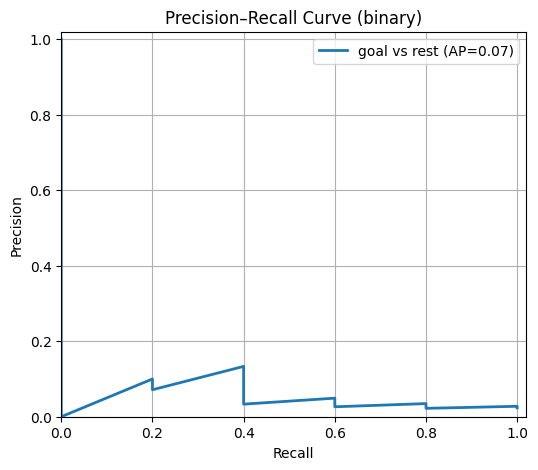

In [21]:
# ── Evaluation (binary: goal vs rest) ─────────────────────────────────────
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_curve, average_precision_score)
import pandas as pd, numpy as np, torch, matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1️⃣  (Optional) load best weights if you saved them
# If you saved manually: torch.save(model.state_dict(), "best.pth")
# model.load_state_dict(torch.load("best.pth", map_location=device))

model.eval()

# 2️⃣  collect logits, probs, labels
logits_all, gts_all = [], []
with torch.no_grad():
    for X, lengths, y in test_loader:
        X, lengths = X.to(device), lengths.to(device)
        logits, _ = model(X, lengths)       # (B,)
        logits_all.append(logits.cpu())
        gts_all.append(y.cpu())

logits_all = torch.cat(logits_all)
gts_all    = torch.cat(gts_all)             # (N,)
probs_all  = torch.sigmoid(logits_all)      # (N,)
preds_all  = (probs_all >= 0.003).long()      # threshold 0.5 (or best_thr if tuned)

# 3️⃣  classification report
print(classification_report(
    gts_all, preds_all,
    labels=[0,1],
    target_names=["not_goal","goal"],
    zero_division=0
))

# 4️⃣  confusion matrix
cm = confusion_matrix(gts_all, preds_all, labels=[0,1])
cm_df = pd.DataFrame(cm,
    index  =[f"True:{n}"      for n in ["not_goal","goal"]],
    columns=[f"Pred:{n}"      for n in ["not_goal","goal"]]
)
display(cm_df.style.background_gradient(axis=None, cmap="Blues"))

# 5️⃣  Precision–Recall curve
y_true  = gts_all.numpy()
y_score = probs_all.numpy()

precision, recall, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, lw=2, label=f"goal vs rest (AP={ap:0.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (binary)")
plt.xlim(0,1.02); plt.ylim(0,1.02)
plt.legend(); plt.grid(True)
plt.show()


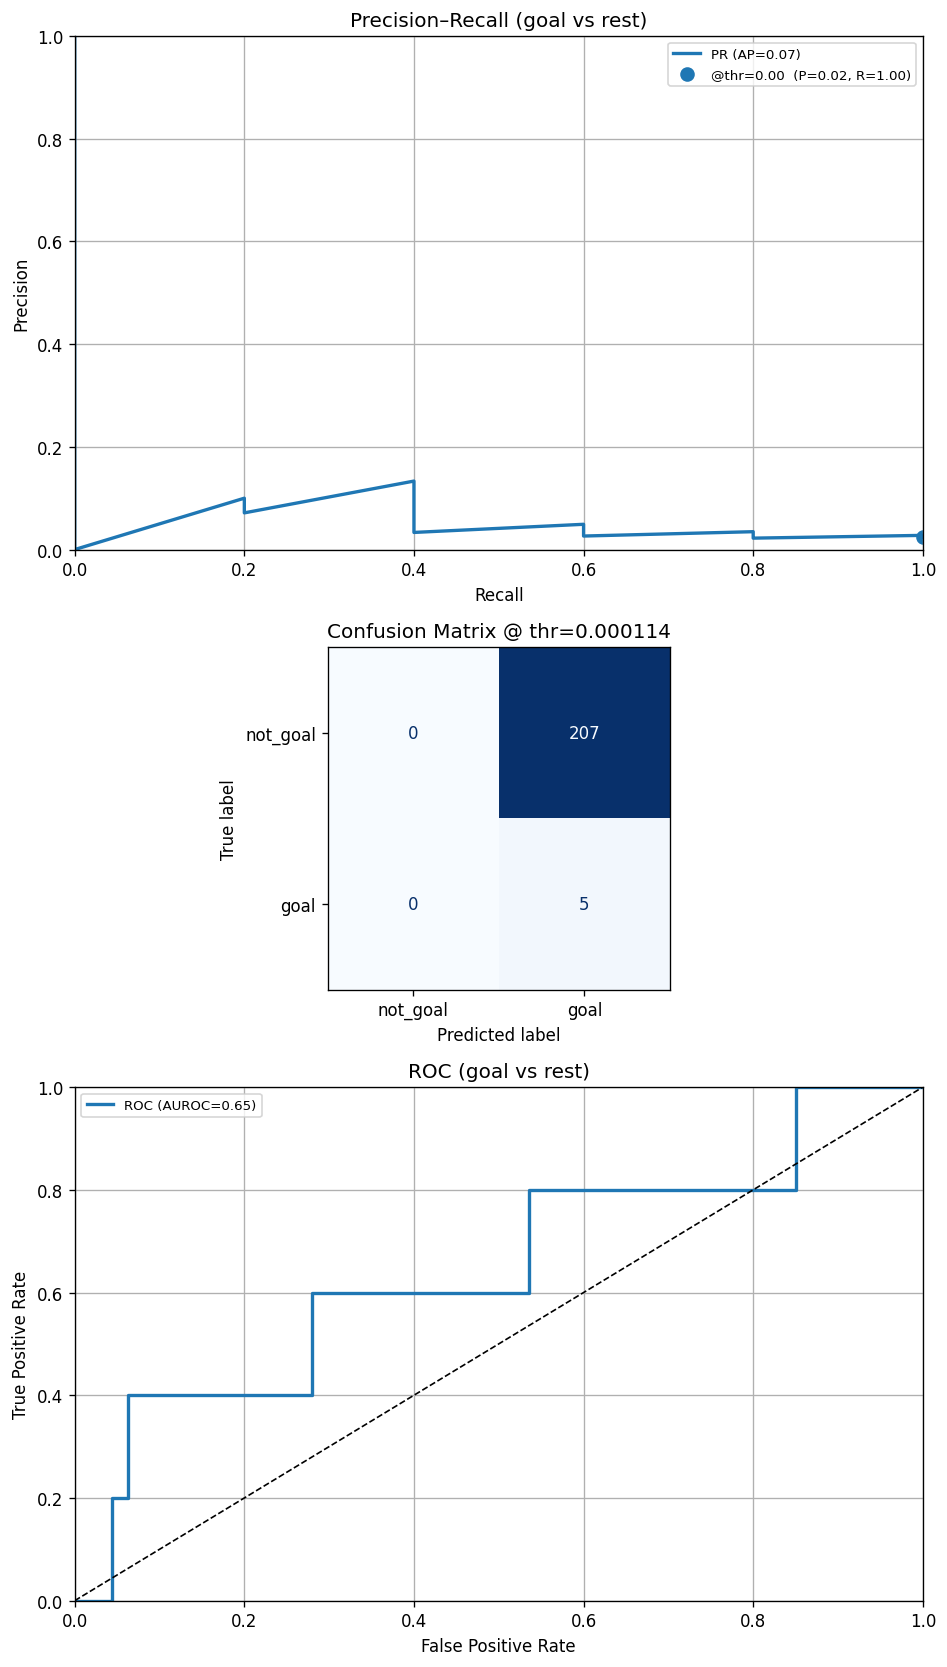

In [22]:


# === REPLACE THE WHOLE CELL WITH THIS (BINARY: goal vs rest) ==============
import numpy as np, matplotlib.pyplot as plt, torch
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score
)

# --- Ensure CPU numpy arrays ---
y_prob = probs_all.detach().cpu().numpy().reshape(-1)   # (N,)  goal probability
y_true = gts_all.detach().cpu().numpy().astype(int)     # (N,)  0=not_goal, 1=goal

# Sanity: clamp probs to [0,1]
y_prob = np.clip(y_prob, 0.0, 1.0)

# Default threshold (override if you have best_thr from training)
try:
    thr = float(best_thr)
except NameError:
    thr = 0.5

# Thresholded predictions
y_pred = (y_prob >= thr).astype(int)

# ---- Curves & metrics ----
# PR
prec, rec, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
auroc = auc(fpr, tpr)

# Point on PR/ROC at chosen threshold
thr_prec = precision_score(y_true, y_pred, zero_division=0)
thr_rec  = recall_score(y_true, y_pred, zero_division=0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

# ---- Plotting ----
fig, (ax_pr, ax_cm, ax_roc) = plt.subplots(3, 1, figsize=(8, 14), dpi=120,
                                           gridspec_kw={'height_ratios':[3,2,3]})

# Precision–Recall
ax_pr.plot(rec, prec, lw=2, label=f"PR (AP={ap:.2f})")
ax_pr.scatter([thr_rec], [thr_prec], s=60, marker='o',
              label=f"@thr={thr:.2f}  (P={thr_prec:.2f}, R={thr_rec:.2f})")
ax_pr.set_title("Precision–Recall (goal vs rest)")
ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
ax_pr.set_xlim(0, 1); ax_pr.set_ylim(0, 1)
ax_pr.grid(True); ax_pr.legend(fontsize=8)

# Confusion Matrix
disp = ConfusionMatrixDisplay(cm, display_labels=["not_goal","goal"])
disp.plot(ax=ax_cm, cmap="Blues", colorbar=False)
ax_cm.set_title(f"Confusion Matrix @ thr={thr:.6f}")

# ROC
ax_roc.plot(fpr, tpr, lw=2, label=f"ROC (AUROC={auroc:.2f})")
ax_roc.plot([0,1], [0,1], "k--", lw=1)
ax_roc.set_title("ROC (goal vs rest)")
ax_roc.set_xlabel("False Positive Rate"); ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_xlim(0, 1); ax_roc.set_ylim(0, 1)
ax_roc.grid(True); ax_roc.legend(fontsize=8)

plt.tight_layout()
plt.show()


### Export to excel

In [23]:
# === EXPORT PREDICTED GOALS (TP-tagged, correct frames) ===================
import pandas as pd, numpy as np, json, os
from pathlib import Path
import cv2
from sklearn.metrics import average_precision_score

# 0) Where to store the continuous CSV (one file across all games)
MASTER_OUT = DATA_ROOT / "outputs" / "GoalPredictions_AllGames.csv"
MASTER_OUT.parent.mkdir(parents=True, exist_ok=True)
WRITE_MASTER_FROM_EXPORT = False   # keep False (review cell will write confirmed rows)

# 1) Identify the game & paths
game      = test_csv.stem.replace("_Throws_lstm_training", "")
game_dir  = test_csv.parent.parent                    # …/Thesis/<GAME>
throws_xlsx = game_dir / "outputs" / f"{game}_Throws_data.xlsx"     # YOLO zones/teams
raw_csv     = test_csv                               # per-frame file used to train LSTM
try:
    video_path = find_video_for_csv(test_csv)        # your helper from earlier cells
except NameError:
    video_path = None

# 2) Helpers: FPS + frame→timestamp
def get_video_fps(path):
    if path is None or not Path(path).exists():
        return 30.0
    cap = cv2.VideoCapture(str(path))
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    cap.release()
    return float(fps)

def frame_to_timestamp(frame_idx, fps):
    if pd.isna(frame_idx) or frame_idx is None:
        return None
    secs = float(frame_idx) / max(float(fps), 1e-6)
    whole = int(secs)
    ms = int(round((secs - whole)*1000))
    h = whole // 3600
    m = (whole % 3600) // 60
    s = (whole % 60)
    return f"{h:02d}:{m:02d}:{s:02d}.{ms:03d}"

fps = get_video_fps(video_path)

# 3) Throw-level meta from raw CSV → Release/End frames
raw = pd.read_csv(raw_csv)
game_tag  = raw_csv.stem.split("_Throws")[0]          # == <GAME>
throw_num = (raw["segment_id"] + 1)//2
raw = raw.assign(throw_number=throw_num,
                 throw_uid   = throw_num.astype(str).radd(f"{game_tag}_"))

def first_release_frame(g):
    g = g.sort_values("frame")
    if "segment_type" in g.columns:
        gf = g[g["segment_type"] == "from"]
        if not gf.empty:
            return int(gf["frame"].iloc[0])
    return int(g["frame"].iloc[0])

def last_to_frame(g):
    if "segment_type" in g.columns:
        tg = g[g["segment_type"] == "to"]
        if not tg.empty:
            return int(tg["frame"].max())
    return int(g["frame"].max())

release_map = raw.groupby("throw_uid", sort=False).apply(first_release_frame).to_dict()
end_map     = raw.groupby("throw_uid", sort=False).apply(last_to_frame).to_dict()

throw_meta = (pd.DataFrame({"throw_uid": list(release_map.keys())})
              .assign(**{
                  "Release Frame": lambda d: d["throw_uid"].map(release_map),
                  "End Frame":     lambda d: d["throw_uid"].map(end_map),
              }))

throw_meta["Game"]         = game
throw_meta["Release Time"] = throw_meta["Release Frame"].apply(lambda fr: frame_to_timestamp(fr, fps))
throw_meta["End Time"]     = throw_meta["End Frame"].apply(lambda fr: frame_to_timestamp(fr, fps))
throw_meta["throw_number"] = throw_meta["throw_uid"].str.rsplit("_", n=1).str[-1].astype(int)

# 4) Read zones/teams from the YOLO Throws Excel (authoritative)
zones = None
if throws_xlsx.exists():
    zones = pd.read_excel(throws_xlsx)
    zones.columns = [c.strip() for c in zones.columns]
    need = {"Throw Number","From Zone","To Zone","Throwing Team","Defending Team"}
    if need.issubset(set(zones.columns)):
        zones = zones[list(need)].copy()
        zones["Throw Number"] = zones["Throw Number"].astype(int)

        # clamp any accidental "10" to "9" while preserving side suffix
        def _clamp_zone(s):
            if pd.isna(s): return s
            s = str(s).strip()
            parts = s.split()
            if not parts: return s
            try:
                n = int(parts[0]); n = min(max(n, 1), 9)
                side = (" " + parts[1]) if len(parts) > 1 else ""
                return f"{n}{side}"
            except:
                return s
        for col in ["From Zone","To Zone"]:
            zones[col] = zones[col].apply(_clamp_zone)
    else:
        print("[WARN] YOLO Throws Excel missing columns:", need - set(zones.columns))
else:
    print(f"[WARN] Not found: {throws_xlsx}")

# 5) Predictions table aligned with test_throw_uids
preds = pd.DataFrame({
    "throw_uid":  test_throw_uids,           # preserved order of test sequences
    "p_goal":     y_prob.reshape(-1),
    "is_goal":    y_pred.astype(int),
    "thr_used":   float(thr),
    "AP_binary":  float(average_precision_score(y_true, y_prob))
})

# add ground-truth and TP flag for ordering in the reviewer
try:
    y_true_arr = np.asarray(y_true, dtype=int)           # already built in your PR cell
    if len(y_true_arr) == len(preds):
        preds["y_true"] = y_true_arr
    else:
        raise ValueError
except Exception:
    try:
        y_true_arr = np.asarray(test_labels, dtype=int)  # fallback
        preds["y_true"] = y_true_arr if len(y_true_arr) == len(preds) else np.nan
    except Exception:
        preds["y_true"] = np.nan

preds["tp_flag"] = (preds["is_goal"] == 1) & (preds["y_true"] == 1)

# 6) Join: preds + throw_meta (+ YOLO zones/teams)
out = preds.merge(throw_meta, on="throw_uid", how="left")
if zones is not None:
    out = out.merge(zones.rename(columns={"Throw Number":"throw_number"}),
                    on="throw_number", how="left")

# 7) Predicted goals only (carry tp_flag & throw_uid; include End Frame/Time)
cols_base = ["Game", "throw_number",
             "From Zone", "To Zone", "Throwing Team", "Defending Team",
             "Release Frame", "Release Time",
             "End Frame", "End Time",
             "p_goal", "thr_used", "AP_binary",
             "tp_flag", "throw_uid"]

for c in ["From Zone","To Zone","Throwing Team","Defending Team"]:
    if c not in out.columns: out[c] = np.nan

goals_only = (out.loc[out["is_goal"] == 1, cols_base]
                .rename(columns={"throw_number":"Throw Number"}))

# 8) (disabled) optional append to master
if WRITE_MASTER_FROM_EXPORT:
    if MASTER_OUT.exists():
        old = pd.read_csv(MASTER_OUT)
        merged = (pd.concat([old, goals_only], ignore_index=True)
                    .drop_duplicates(subset=["Game","Throw Number"], keep="last"))
        merged.to_csv(MASTER_OUT, index=False)
    else:
        goals_only.to_csv(MASTER_OUT, index=False)

print(f"[OK] Prepared {len(goals_only)} predicted goals for {game} (TPs flagged).")


C:\Users\USER\AppData\Local\Temp\ipykernel_21020\2803454809.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  release_map = raw.groupby("throw_uid", sort=False).apply(first_release_frame).to_dict()
C:\Users\USER\AppData\Local\Temp\ipykernel_21020\2803454809.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  end_map     = raw.groupby("throw_uid", sort=False).apply(last_to_frame).to_dict()


[OK] Prepared 212 predicted goals for TUR_-_BRA_3-1 (TPs flagged).


### Human review

In [24]:
# === HUMAN REVIEW (TP-first, release→end playback) ========================
# Requires: goals_only, DATA_ROOT, game, video_path, fps, frame_to_timestamp
import os, re, cv2, pandas as pd, numpy as np
from pathlib import Path
from datetime import datetime

# --------------------------------------------------------------------------
# Paths for reviewer state / master file
# --------------------------------------------------------------------------
DECISIONS_CSV = DATA_ROOT / "outputs" / "GoalPredictions_Decisions.csv"  # persistent log of decisions (all games)
MASTER_OUT    = DATA_ROOT / "outputs" / "GoalPredictions_AllGames.csv"   # CONFIRMED rows only (all games)
MASTER_OUT.parent.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------------------------------
# Helpers
# --------------------------------------------------------------------------
def overlay_text(img, lines, org=(12, 28), lh=26):
    for i, t in enumerate(lines):
        y = org[1] + i * lh
        cv2.putText(img, t, (org[0], y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 4, cv2.LINE_AA)
        cv2.putText(img, t, (org[0], y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1, cv2.LINE_AA)
    return img

def play_clip_and_get_key_range(cap, start_frame: int, end_frame: int,
                                loop_ms: int = 30, win: str = "GoalReview"):
    """Loop video from start_frame..end_frame (inclusive) until a decision key is pressed."""
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) if cap is not None else None
    start = max(int(start_frame), 0)
    end   = int(end_frame)
    if total is not None:
        end = min(end, total - 1)

    frame = start
    cv2.namedWindow(win, cv2.WINDOW_NORMAL)
    try: cv2.resizeWindow(win, 960, 540)
    except: pass

    while True:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
        ok, img = cap.read()
        if not ok:
            break
        cv2.imshow(win, img)
        key = cv2.waitKey(loop_ms) & 0xFF
        if key in (ord('1'), ord('0'), ord('s'), ord('q'), 27):
            return key
        frame += 1
        if frame > end:
            frame = start

def safe_write_master(master_path: Path, confirmed_rows: pd.DataFrame, game_name: str):
    """Rewrite master so it contains ONLY confirmed rows for `game_name` (keep other games intact)."""
    try:
        if master_path.exists():
            old = pd.read_csv(master_path)
            old = old[old["Game"] != game_name]  # purge any previous rows for this game
            merged = (pd.concat([old, confirmed_rows], ignore_index=True)
                      .drop_duplicates(subset=["Game", "Throw Number"], keep="last")
                      .sort_values(["Game", "Throw Number"]))
            merged.to_csv(master_path, index=False)
        else:
            confirmed_rows.sort_values(["Game", "Throw Number"]).to_csv(master_path, index=False)
        print(f"[OK] Updated master with CONFIRMED ONLY for {game_name} → {master_path}")
    except PermissionError:
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        pend = master_path.with_name(f"{master_path.stem}_confirmed_pending_{game_name}_{ts}.csv")
        confirmed_rows.to_csv(pend, index=False)
        print(f"[WARN] Master locked; wrote pending confirmed → {pend}")

# --------------------------------------------------------------------------
# Halftime flip: mirror zones and swap Upper/Lower for second half
# Handles 'SS', 'MM:SS(.s)', and 'HH:MM:SS(.s)' time formats
# --------------------------------------------------------------------------
goals_only = goals_only.copy()  # avoid SettingWithCopy

def to_seconds_flex(ts) -> float:
    try:
        s = str(ts).strip()
        if not s or s.lower() in {"nan", "none"}:
            return np.nan
        parts = s.split(":")
        if len(parts) == 3:   # HH:MM:SS(.s)
            h, m, sec = int(parts[0]), int(parts[1]), float(parts[2])
            return h * 3600 + m * 60 + sec
        elif len(parts) == 2: # MM:SS(.s)
            m, sec = int(parts[0]), float(parts[1])
            return m * 60 + sec
        elif len(parts) == 1: # SS(.s)
            return float(parts[0])
        else:
            return np.nan
    except Exception:
        return np.nan

_zone_rx = re.compile(r"^\s*(\d+)\s+([Uu]pper|[Ll]ower)\s*$")
def flip_zone_str(z: str) -> str:
    m = _zone_rx.match(str(z))
    if not m:
        return z
    num = int(m.group(1))
    side = m.group(2).lower()
    flipped_num  = 10 - num
    flipped_side = "Upper" if side.startswith("l") else "Lower"
    return f"{flipped_num} {flipped_side}"

HALFTIME_MMSS = "24:00"                       # change if your games use a different split
HALFTIME_SEC  = to_seconds_flex(HALFTIME_MMSS)

# prefer Release Time, else End Time
release_sec = goals_only["Release Time"].apply(to_seconds_flex)
end_sec     = goals_only["End Time"].apply(to_seconds_flex)
time_sec    = release_sec.where(~release_sec.isna(), end_sec)

mask_time = time_sec >= HALFTIME_SEC
bad_time  = time_sec.isna()

# Fallback when time strings couldn't be parsed: split by throw index
if bad_time.any():
    mid_throw = goals_only["Throw Number"].median()
    mask_time = mask_time.fillna(False)
    mask_time.loc[bad_time] = goals_only.loc[bad_time, "Throw Number"] > mid_throw

for col in ["From Zone", "To Zone"]:
    goals_only.loc[mask_time, col] = goals_only.loc[mask_time, col].map(flip_zone_str)

print(f"[Halftime flip] Time parse failed for {int(bad_time.sum())} rows; "
      f"flipped {int(mask_time.sum())} rows at/after {HALFTIME_MMSS}.")

# --------------------------------------------------------------------------
# Build review table (TPs first)
# --------------------------------------------------------------------------
cols_keep = [
    "Game","Throw Number","From Zone","To Zone",
    "Throwing Team","Defending Team",
    "Release Frame","Release Time",
    "End Frame","End Time",
    "p_goal","thr_used","AP_binary",
    "tp_flag","throw_uid"
]
present = [c for c in cols_keep if c in goals_only.columns]  # be robust to schema drift
review_df = goals_only[present].copy()

review_df["key"] = review_df["Game"].astype(str) + "___" + review_df["Throw Number"].astype(str)

# load/merge prior decisions (to resume)
if DECISIONS_CSV.exists():
    decisions = pd.read_csv(DECISIONS_CSV)
else:
    decisions = pd.DataFrame(columns=["key","is_real","reviewer","reviewed_at"])

review_df = review_df.merge(decisions[["key","is_real"]], on="key", how="left")

# queue: TP first by high p, then non-TP by high p
to_review_all = review_df[review_df["is_real"].isna()].copy()
tp_part = to_review_all[to_review_all["tp_flag"] == True].sort_values("p_goal", ascending=False)
fp_part = to_review_all[to_review_all["tp_flag"] != True].sort_values("p_goal", ascending=False)
to_review = pd.concat([tp_part, fp_part], ignore_index=True)

print(f"Predicted positives for {game}: {len(review_df)} | to review now: {len(to_review)} "
      f"(TP-first; TP={tp_part.shape[0]}, FP={fp_part.shape[0]})")

# open video
if video_path is None or not Path(video_path).exists():
    print("[WARN] video file not found; showing info panel instead.")
cap = cv2.VideoCapture(str(video_path)) if (video_path and Path(video_path).exists()) else None

# --------------------------------------------------------------------------
# Review loop
# --------------------------------------------------------------------------
for i, row in to_review.iterrows():
    rel_fr = int(row["Release Frame"])
    end_fr = int(row["End Frame"]) if pd.notna(row["End Frame"]) else rel_fr + 80
    if end_fr < rel_fr:
        end_fr = rel_fr + 80

    print(f"\n[{i+1}/{len(to_review)}] Throw #{row['Throw Number']}  "
          f"p={row['p_goal']:.3f}  {'[TP]' if bool(row.get('tp_flag')) else '[FP?]'}  "
          f"{row['Release Time']} → {row.get('End Time','')}")

    if cap is not None:
        # header frame with overlay
        cap.set(cv2.CAP_PROP_POS_FRAMES, rel_fr)
        ok, img = cap.read()
        if ok:
            lines = [
                f"{game} | Throw #{row['Throw Number']}  p={row['p_goal']:.3f}  "
                f"{'TP' if bool(row.get('tp_flag')) else 'FP?'}",
                f"{row['Throwing Team']} → {row['Defending Team']}    "
                f"{row['From Zone']} → {row['To Zone']}",
                f"{row['Release Time']} → {row.get('End Time','')}  (frames {rel_fr}..{end_fr})",
                "Keys: 1=Goal  0=Not goal  s=Skip  q/Esc=Quit"
            ]
            img = overlay_text(img.copy(), lines)
            cv2.namedWindow("GoalReview", cv2.WINDOW_NORMAL)
            try: cv2.resizeWindow("GoalReview", 960, 540)
            except: pass
            cv2.imshow("GoalReview", img); cv2.waitKey(1)

        key = play_clip_and_get_key_range(cap, max(rel_fr-10, 0), end_fr, loop_ms=30, win="GoalReview")
    else:
        # no video → show info panel
        panel = 255 * np.ones((480, 960, 3), dtype=np.uint8)
        lines = [
            f"{game} | Throw #{row['Throw Number']}  p={row['p_goal']:.3f}  "
            f"{'TP' if bool(row.get('tp_flag')) else 'FP?'}",
            f"{row['Throwing Team']} → {row['Defending Team']}    "
            f"{row['From Zone']} → {row['To Zone']}",
            f"{row['Release Time']} → {row.get('End Time','')} (no video)",
            "Keys: 1=Goal  0=Not goal  s=Skip  q/Esc=Quit"
        ]
        panel = overlay_text(panel, lines)
        cv2.namedWindow("GoalReview", cv2.WINDOW_NORMAL)
        cv2.imshow("GoalReview", panel)
        key = cv2.waitKey(0) & 0xFF

    if key in (ord('q'), 27):  # quit
        print("Quitting review…"); break
    elif key == ord('1'): is_real = 1
    elif key == ord('0'): is_real = 0
    elif key == ord('s'): print("Skipped."); continue
    else: print("Unknown key; skipped."); continue

    # upsert decision
    try:
        reviewer = os.getlogin()
    except Exception:
        reviewer = ""
    new_row = {
        "key": row["key"],
        "is_real": is_real,
        "reviewer": reviewer,
        "reviewed_at": datetime.now().isoformat(timespec="seconds"),
    }
    decisions = decisions[decisions["key"] != row["key"]]
    decisions = pd.concat([decisions, pd.DataFrame([new_row])], ignore_index=True)
    decisions.to_csv(DECISIONS_CSV, index=False)
    print(f"Saved decision is_real={is_real}")

# cleanup
if cap is not None: cap.release()
cv2.destroyAllWindows()

# --------------------------------------------------------------------------
# Write CONFIRMED rows for THIS game to the master
# --------------------------------------------------------------------------
latest    = review_df.drop(columns=["is_real"]).merge(decisions[["key","is_real"]], on="key", how="left")
confirmed = latest[(latest["is_real"] == 1) & (latest["Game"] == game)].drop(columns=["key","is_real"])
print(f"\nConfirmed={len(confirmed)} rows for {game}")
safe_write_master(MASTER_OUT, confirmed, game)


[Halftime flip] Time parse failed for 0 rows; flipped 104 rows at/after 24:00.
Predicted positives for TUR_-_BRA_3-1: 212 | to review now: 212 (TP-first; TP=5, FP=207)

[1/212] Throw #70  p=0.209  [TP]  00:16:05.583 → 00:16:06.417
Saved decision is_real=1

[2/212] Throw #21  p=0.018  [TP]  00:03:52.083 → 00:03:20.792
Saved decision is_real=0

[3/212] Throw #185  p=0.001  [TP]  00:43:59.500 → 00:43:58.375
Saved decision is_real=0

[4/212] Throw #58  p=0.000  [TP]  00:13:55.167 → 00:13:19.792
Saved decision is_real=0

[5/212] Throw #28  p=0.000  [TP]  00:05:49.917 → 00:05:11.292
Saved decision is_real=0

[6/212] Throw #170  p=0.996  [FP?]  00:38:58.292 → 00:39:01.458


KeyboardInterrupt: 

inspect label Distribution

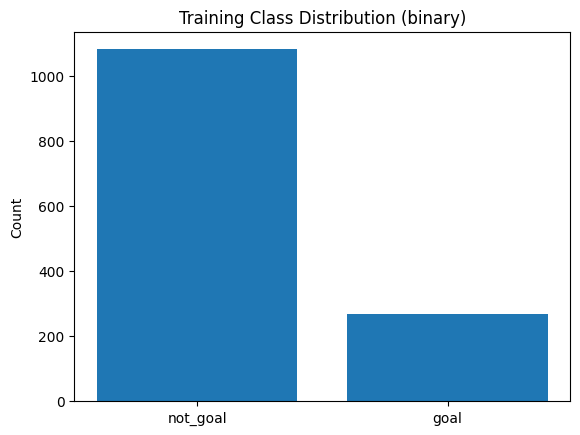

Counts: {'not_goal': 1083, 'goal': 268}


In [ ]:
import collections
import matplotlib.pyplot as plt

label_names = ["not_goal", "goal"]
counts = collections.Counter(train_labels)

plt.bar(label_names, [counts[i] for i in range(2)])
plt.title("Training Class Distribution (binary)")
plt.ylabel("Count")
plt.show()

print("Counts:", {name: counts[i] for i, name in enumerate(label_names)})


Save the model

In [ ]:
(df_test_clean                      # ← already scaled/clean DataFrame
 .groupby("throw_uid")["class_id"]  # one row per physical throw
 .first()                           # each uid has a single class_id
 .value_counts())                   # how many throws per class


class_id
4    194
0     17
2     11
1      2
Name: count, dtype: int64

In [ ]:
# torch.save({
#     "model_state": model.state_dict(),
#     "scaler_state": scaler,              # reuse at inference
#     "feature_cols": FEATURE_COLS
# }, "throw_lstm_v1.pt")

# print("Model saved → throw_lstm_v1.pt")


If need to pip install anything on my PC - GPU:

import sys, os, platform
print("Kernel executable :", sys.executable)
print("Python version    :", platform.python_version())


then:

"<path-from-sys.executable>" -m pip install --upgrade torchmetrics